# TDVP for TTN

This notebook demonstrates the capabilities of the TDVP algorithm for TreeTensorNetworks implemented in `pytreenet/time_evolution/tdvp.py`.

Overview:
### 1. TDVP for MPS: Single qubit rotation on Bloch Sphere
- Set up TTN and verify its properties
- Run TDVP simulation
- Validate results by comparison to analytical result
### 2. TDVP for MPS: Two-qubit system evolution under Heisenberg Hamiltonian
- Set up TTN and verify its properties
- Run TDVP simulation
- Validate results by comparison to analytical result

### 3. TDVP for MPS: Multi-qubit system evolution under Heisenberg Hamiltonian
- Set up TTN and verify its properties
- Run TDVP simulation
- Validate results by comparison to analytical result

## STILL TO DO:

- Analyze error and runtime for varying bond dimension
### 4. TDVP for Bosonic Tree model
- Set up TTN, verify its properties and visualize the network structure
- Run TDVP simulation
- Compare results and performance to TEBD algorithm (as implemented in `pytreenet/time_evolution/tebd.py`)

In [1]:
# Import PyTreeNet from local folders
import sys
sys.path.append('..')
import pytreenet as ptn

import numpy as np
import matplotlib.pyplot as plt

In [2]:
import scipy
from copy import deepcopy

In [3]:
X, Y, Z = ptn.util.pauli_matrices()

## TDVP for MPS: Single qubit rotation on Bloch Sphere
### Set up TTN and verify its properties

Hamiltonian:

$H = X$

Initial State:  

$\ket{\psi} = \ket{0}$

In [4]:
mps = ptn.QuantumTTState()
psi = np.array([1, 0], dtype=complex)
mps_node = ptn.QuantumStateNode(psi, identifier="node")
mps.add_root(mps_node)

mps["node"].tensor

array([1.+0.j, 0.+0.j])

In [5]:
ham = ptn.QuantumTTOperator()
ham_node = ptn.QuantumOperatorNode(X, identifier="node")
ham.add_root(ham_node)

ham["node"].tensor

array([[0.+0.j, 1.+0.j],
       [1.+0.j, 0.+0.j]])

## TDVP for MPS: Single qubit rotation on Bloch Sphere
Run TDVP simulation for 1 with time step size of 0.001

In [6]:
time_step_size = 0.001
final_time = 1

operators = [{node_id: Z} for node_id in mps.nodes]


tdvp_sim = ptn.TDVP(deepcopy(mps), deepcopy(ham), time_step_size=time_step_size, final_time=final_time, operators=operators)
tdvp_sim.run()

100%|██████████| 1001/1001 [00:01<00:00, 980.83it/s]


## TDVP for MPS: Single qubit rotation on Bloch Sphere
Validate results by comparison to analytical result

In [7]:
psi_init_ref = np.array([1, 0], dtype=complex)
ham_ref = X
operators_ref = [Z]

num_time_steps = int(np.ceil(final_time / time_step_size))
results = np.zeros((len(operators) + 1, num_time_steps + 1), dtype=complex)

psi_ref = psi_init_ref
for time_step in range(num_time_steps + 1):
    if time_step != 0:
        psi_ref = ptn.fast_exp_action(-1j*time_step_size*ham_ref, psi_ref)

    for i, operator in enumerate(operators_ref):
        results[i,time_step] = np.conjugate(psi_ref) @ operator @ psi_ref
        
    results[-1,time_step] = time_step * time_step_size

In [8]:
results_ref = results
results_tdvp = tdvp_sim.results
error_abs = results_ref[0] - results_tdvp[0]

print(np.allclose(error_abs, 0))

True


## TDVP for MPS: Two-qubit system evolution under Heisenberg Hamiltonian
Set up TTN and verify its properties

Hamiltonian (OBC):

$H = m_J \cdot X_1X_2 + m_g \cdot (Z_1+Z_2$)

Initial State:  

$\ket{\psi} = \ket{0}$

In [9]:
num_sites = 2
virtual_bond_dimension = 2
mJ = 1.5
mg = 0.5

In [10]:
mps = ptn.models.mps_zero(num_sites, virtual_bond_dimension)
ham = ptn.models.mps_heisenberg(num_sites, mJ, 0, 0, mg)

In [11]:
node_shapes = {node_id: mps.nodes[node_id].tensor.shape for node_id in mps.nodes}
print("MPS site shapes:", node_shapes)

node_shapes = {node_id: ham.nodes[node_id].tensor.shape for node_id in ham.nodes}
print("MPO site shapes:", node_shapes)

MPS site shapes: {'site0': (2, 2), 'site1': (2, 2)}
MPO site shapes: {'site0': (3, 2, 2), 'site1': (3, 2, 2)}


## TDVP for MPS: Two-qubit system evolution under Heisenberg Hamiltonian
Run TDVP simulation for 1 with time step size of 0.001

In [12]:
time_step_size = 0.001
final_time = 1
operators = [{node_id: Z} for node_id in mps.nodes]

tdvp_sim = ptn.TDVP(deepcopy(mps), deepcopy(ham), time_step_size=time_step_size, final_time=final_time, operators=operators)
tdvp_sim.run()

100%|██████████| 1001/1001 [00:04<00:00, 232.68it/s]


## TDVP for MPS: Two-qubit system evolution under Heisenberg Hamiltonian

Validate results by comparison to analytical result

In [13]:
zero_state = np.asarray([1,0], dtype=complex)
ref_state = zero_state
for site in range(1, num_sites):
    ref_state = np.kron(ref_state, zero_state)

ref_hamiltonian = np.zeros((2**num_sites, 2**num_sites), dtype=complex)
I = np.eye(2)

# Two-site terms
for site in range(0,num_sites-1):
    operator = np.asarray([1])
    for site2 in range(0,num_sites):
        
        if site2 == site:
            operator = np.kron(operator, mJ*X)
        elif site2 == site+1:
            operator = np.kron(operator, X)
        else:
            operator = np.kron(operator, I)
    ref_hamiltonian += operator
    
# Single-site terms
for site in range(0,num_sites):
    operator = np.asarray([1])
    for site2 in range(0,num_sites):
        if site2 == site:
            operator = np.kron(operator, mg*Z)
        else:
            operator = np.kron(operator, I)
    ref_hamiltonian += operator

In [14]:
operators = []

for sites in range(num_sites):
    site_operator = np.asarray([1])
    for sites2 in range(num_sites):
        if sites2 == sites:
            site_operator = np.kron(site_operator, Z)
        else:
            site_operator = np.kron(site_operator, I)
    operators.append(site_operator)

In [15]:
results = ptn.state_vector_time_evolution(ref_state, ref_hamiltonian, final_time, time_step_size, operators)

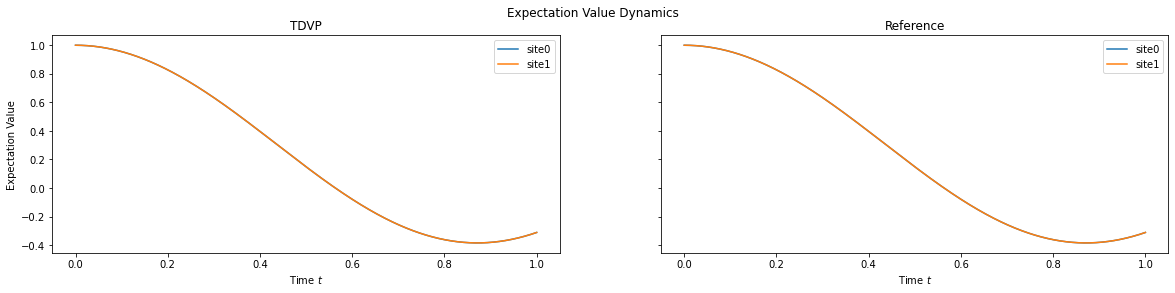

In [16]:
ref_times = [time.real for time in results[-1]]

fig, axs = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(20,4))

fig.suptitle("Expectation Value Dynamics")

for site in range(num_sites):
    axs[0].plot([time.real for time in tdvp_sim.results[-1]], [exp_val.real for exp_val in tdvp_sim.results[site]], label="site"+str(site))

axs[0].legend()
axs[0].set_ylabel("Expectation Value")
axs[0].set_xlabel("Time $t$")
axs[0].set_title("TDVP")

for site in range(num_sites):
    axs[1].plot(ref_times, [exp_val.real for exp_val in results[site]], label="site"+str(site))

axs[1].legend()
axs[1].set_xlabel("Time $t$")
axs[1].set_title("Reference")

plt.show()

## TDVP for MPS: Multi-qubit system evolution under Heisenberg Hamiltonian
Set up TTN and verify its properties

Hamiltonian (OBC):

$H = m_J \cdot X_iX_{i+1} + m_g \cdot Z_i$

Initial State:  

$\ket{\psi} = \ket{0}$

In [17]:
num_sites = 5
virtual_bond_dimension = 8
mJ = 1.5
mg = 0.5

In [18]:
mps = ptn.models.mps_zero(num_sites, virtual_bond_dimension)
ham = ptn.models.mps_heisenberg(num_sites, mJ, 0, 0, mg)

In [19]:
node_shapes = {node_id: mps.nodes[node_id].tensor.shape for node_id in mps.nodes}
print("MPS site shapes:", node_shapes)

node_shapes = {node_id: ham.nodes[node_id].tensor.shape for node_id in ham.nodes}
print("MPO site shapes:", node_shapes)

MPS site shapes: {'site0': (8, 2), 'site1': (8, 8, 2), 'site2': (8, 8, 2), 'site3': (8, 8, 2), 'site4': (8, 2)}
MPO site shapes: {'site0': (3, 2, 2), 'site1': (3, 3, 2, 2), 'site2': (3, 3, 2, 2), 'site3': (3, 3, 2, 2), 'site4': (3, 2, 2)}


## TDVP for MPS: Multi-qubit system evolution under Heisenberg Hamiltonian
Run TDVP simulation for 1 with time step size of 0.001

In [20]:
time_step_size = 0.001
final_time = 1
operators = [{node_id: Z} for node_id in mps.nodes]

tdvp_sim = ptn.TDVP(deepcopy(mps), deepcopy(ham), time_step_size=time_step_size, final_time=final_time, operators=operators)

In [21]:
tdvp_sim.run()

100%|██████████| 1001/1001 [00:54<00:00, 18.35it/s]


## TDVP for MPS: Two-qubit system evolution under Heisenberg Hamiltonian

Validate results by comparison to analytical result

In [22]:
zero_state = np.asarray([1,0], dtype=complex)
ref_state = zero_state
for site in range(1, num_sites):
    ref_state = np.kron(ref_state, zero_state)

ref_zero_state = ref_state
ref_hamiltonian = np.zeros((2**num_sites, 2**num_sites), dtype=complex)
I = np.eye(2)

# Two-site terms
for site in range(0,num_sites-1):
    operator = np.asarray([1])
    for site2 in range(0,num_sites):
        
        if site2 == site:
            operator = np.kron(operator, X)
        elif site2 == site+1:
            operator = np.kron(operator, mJ*X)
        else:
            operator = np.kron(operator, I)
    ref_hamiltonian += operator
    
# Single-site terms
for site in range(0,num_sites):
    operator = np.asarray([1])
    for site2 in range(0,num_sites):
        if site2 == site:
            operator = np.kron(operator, mg*Z)
        else:
            operator = np.kron(operator, I)
    ref_hamiltonian += operator

In [23]:
operators = []

for sites in range(num_sites):
    site_operator = np.asarray([1])
    for sites2 in range(num_sites):
        if sites2 == sites:
            site_operator = np.kron(site_operator, Z)
        else:
            site_operator = np.kron(site_operator, I)
    operators.append(site_operator)

In [24]:
results = ptn.state_vector_time_evolution(ref_state, ref_hamiltonian, final_time, time_step_size, operators)

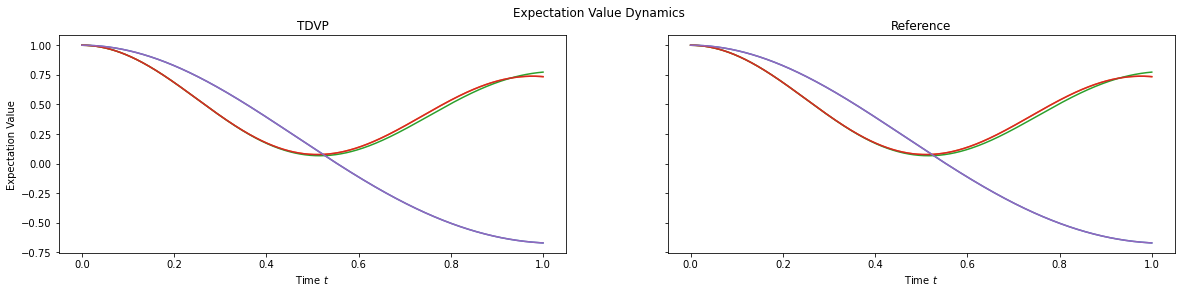

In [25]:
ref_times = [time.real for time in results[-1]]

fig, axs = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(20,4))

fig.suptitle("Expectation Value Dynamics")

for site in range(num_sites):
    axs[0].plot([time.real for time in tdvp_sim.results[-1]], [exp_val.real for exp_val in tdvp_sim.results[site]])

axs[0].set_ylabel("Expectation Value")
axs[0].set_xlabel("Time $t$")
axs[0].set_title("TDVP")

for site in range(num_sites):
    axs[1].plot(ref_times, [exp_val.real for exp_val in results[site]])

axs[1].set_xlabel("Time $t$")
axs[1].set_title("Reference")

plt.show()